In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from zipfile import ZipFile
import sys
from PIL import Image
sys.modules['Image'] = Image 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio


batch_size = 32
image_size = 64
latent_dim = 64

# archive with images of different emojis
with ZipFile("archive_emoji_apple.zip", "r") as zipobj:
    try:
        zipobj.extractall("image_emoji_apple")
    except OSError as exc:
        if exc.errno == 36:
            pass
        else:
            raise exc
    
    
dataset = keras.preprocessing.image_dataset_from_directory(
    "image_emoji_apple", label_mode=None, image_size=(64, 64), batch_size=batch_size
)
dataset = dataset.map(lambda x: x / 255.0)


discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

d_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0001)


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator and update metrics
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_emoji_%03d_%d.png" % (epoch, i))
            image_current=Image.open("generated_emoji_%03d_%d.png" % (epoch, i))
            

    
gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=10, callbacks=[GANMonitor(num_img=2, latent_dim=latent_dim)]
)



Found 1813 files belonging to 1 classes.
Epoch 1/10
57/57 [==============================] - 383s 7s/step - d_loss: 0.5184 - g_loss: 1.1989
Epoch 2/10
57/57 [==============================] - 382s 7s/step - d_loss: 0.3814 - g_loss: 1.9747
Epoch 3/10
57/57 [==============================] - 377s 7s/step - d_loss: 0.5017 - g_loss: 1.6988
Epoch 4/10
57/57 [==============================] - 377s 7s/step - d_loss: 0.4678 - g_loss: 2.7610
Epoch 5/10
57/57 [==============================] - 381s 7s/step - d_loss: 0.5671 - g_loss: 1.5808
Epoch 6/10
57/57 [==============================] - 365s 6s/step - d_loss: 0.5662 - g_loss: 1.7450
Epoch 7/10
57/57 [==============================] - 353s 6s/step - d_loss: 0.7118 - g_loss: 0.9588
Epoch 8/10
57/57 [==============================] - 352s 6s/step - d_loss: 0.4841 - g_loss: 1.6601
Epoch 9/10
57/57 [==============================] - 353s 6s/step - d_loss: 0.6557 - g_loss: 1.3849
Epoch 10/10
57/57 [==============================] - 352s 6s/step - 

Generated images, 1, 5, 10 epoch


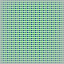

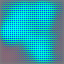

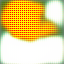

In [19]:
from IPython.display import Image
from IPython.display import display
 
image_current_first_epoch=Image(filename="generated_emoji_000_0.png")
image_current_fifth_epoch=Image(filename="generated_emoji_004_0.png")
image_current_last_epoch=Image(filename="generated_emoji_009_0.png")

print("Generated images, 1, 5, 10 epoch")

#The results are not good enough, but to make it more clear it needs more time to train (more epochs)
display(image_current_first_epoch, image_current_fifth_epoch, image_current_last_epoch)